# Анализ товарного ассортимента в e-commerce 

Презентация: https://disk.yandex.ru/i/_45jkXjC0VUcQQ

__Цель работы:__ Определить основной и дополнительный ассортимент магазина товаров для дома

__Датасет о покупках:__
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

__Задачи работы:__

*1. Выполнить предобработку данных*
- Исследовать пропущенные значения;
- Исследовать соответствие типов;
- Исследовать дубликаты;
- Проверить корректность наименований колонок;
- Переименовать колонки;
- Удалить дубликаты;
- Привести типы;
- Заменить пропущенные значения;
- Найти выбросы, отфильтровать их;
- Распределить товары по 5-6 категориям;
- Создать столбцы с часом и днем недели покупки;
- Проверить соответствие данных ТЗ.

*2. Провести исследовательский анализ данных*
- Изучить параметры заказов: средняя стоимость и число товаров в чеке;
- Изучить динамику количества и объема заказов по времени заказа;
- Изучить зависимость числа и объема заказов от временных интервалов в разные дня недели;
- Изучить поведение пользователей: как часто заказывают, среднее число заказов на пользователя, доля пользователей с более чем одной покупкой;
- Сравнить продаваемость категорий: доля выручки, количество;
- Ранжировать товары по выручке и проданному количеству внутри каждой категории.

*3. Выделить основной и дополнительный ассортимент*
- Провести ABC-анализ по выручке и проданному количеству товарных позиций;
- Разбивка на категории: А - до 80%, B - 80-95%, C- 95-100%;
- Товар считается основным, если имеет хотя бы одну A. От товара C&C стоит избавиться, остальные - дополнительные.

*4. Сформулировать 2-3 гипотезы*

### Предобработка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns
  
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

In [2]:
# загрузка файла
data = pd.read_csv('ecom_dataset_upd.csv')

In [3]:
# вывод основной информации и поиск дубликатов и пустых ячеек
display(data.head())
print(data.info())
print('Кол-во дубликатов:', data.duplicated().sum())
print('Пустые ячейки:\n', data.isna().sum().sort_values(ascending=False))

# число строк
len_data = data['order_id'].count()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB
None
Кол-во дубликатов: 0
Пустые ячейки:
 date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64


- В датафрейме представлена информация о проданных продуктах;
- Дата покупки - в формате год, месяц, день и час;
- Также в таблице название проданного товара, его количество в чеке, цена, номер заказа и айди пользователя;
- Всего 7474 строк, нет пустых ячеек и явных дубликатов.

Далее поищу неявные дубликаты. Для начала - заказы с более чем одним клиентом:

In [4]:
# заказы с 2 и более клиентами
orders_dublicated = (data
                     .groupby('order_id')
                     .agg(count_users=('customer_id', 'nunique'))
                     .query('count_users > 1').reset_index()['order_id'])

# доля повторяющихся заказов
share_dublicated_orders = orders_dublicated.count() / data['order_id'].count() * 100
print('Доля дубликатов среди заказов с несколькими пользователями равна {:.2f}%.'.format(share_dublicated_orders))

Доля дубликатов среди заказов с несколькими пользователями равна 0.39%.


Доля задублированных заказов с несколькими пользователями заметно меньше 5% - можно удалить их.

In [5]:
# удаление дубликатов
data_raw = data.query('~order_id.isin(@orders_dublicated)')

Теперь проверю заказы с более чем одной датой

In [6]:
# заказы с несколькими датами
orders_dublicated_date = (data
                     .groupby('order_id')
                     .agg(count_dates=('date', 'nunique'))
                     .query('count_dates > 1').reset_index().sort_values(by='count_dates', ascending=False))

orders_dublicated_date

,order_id,count_dates
20,14833,74
157,70960,60
53,69162,23
168,71148,16
77,69531,12
...,...,...
118,70424,2
119,70438,2
120,70450,2
122,70476,2


284 номера заказа имеют две и более даты, найду количество уникальных заказов в датасете:

In [7]:
print('Число уникальных заказов равно:', data['order_id'].nunique())

Число уникальных заказов равно: 3521


In [8]:
# пример заказа с разными датами
data.query('order_id == 13547')

,date,customer_id,order_id,product,quantity,price
102,2018100500,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
103,2018100500,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
104,2018100500,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
376,2018102313,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
377,2018102313,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
378,2018102313,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
509,2018102819,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
510,2018102819,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
511,2018102819,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
588,2018110214,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0


Уникальный номер заказа может говорить о том, что он был оплачен единажды, ведь при повторном - его номер поменялся бы, пусть даже с теми же товарами. Возьму максимальную дату заказа и удалю строки, чья дата не равна максимальной. Мощность датасета уменьшится, но зато не будет дубликатов и смещений по заказам.

In [9]:
# для каждого заказа напишу самую позднюю дату
data['max_date'] = data.groupby('order_id')['date'].transform('max')

In [10]:
# обрежу повторяющиеся заказы
data = data.query('date == max_date')

# удалю вспомогательный столбец
data = data.drop(columns='max_date').reset_index(drop=True)

In [11]:
# пример заказа с разными датами
data.query('order_id == 13547')

,date,customer_id,order_id,product,quantity,price
693,2018111616,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
694,2018111616,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
695,2018111616,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0


In [12]:
# доля дубликатов
share_dublicated_orders = (1 -  data['order_id'].count() / len_data) * 100
print('Доля дубликатов среди заказов с несколькими датами равна {:.2f}%.'.format(share_dublicated_orders))

Доля дубликатов среди заказов с несколькими датами равна 26.17%.


Пришлось удалить четверть базы, но зато избавился от смещения данных из-за длительного формирования заказов. Дубликатов нет!

In [13]:
# работа с форматом даты покупки
data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H'))

In [14]:
# добавление стоимости проданных товаров
data['value'] = data['quantity'] * data['price']

In [15]:
# добавление столбцов с временными интервалами
data['day'] = pd.to_datetime(data['date']).dt.date
data['hour'] = pd.to_datetime(data['date']).dt.hour
data['weekday'] = pd.to_datetime(data['date']).dt.weekday
data['month'] = pd.to_datetime(data['date']).dt.month
data['year'] = pd.to_datetime(data['date']).dt.year
data.head(1)

print('В датасете представлены данные по заказам, сделанным с', data['day'].min(), 'по', data['day'].max())

В датасете представлены данные по заказам, сделанным с 2018-10-01 по 2020-01-31


Для анализа есть три последних месяца 2018, весь 2019 и январь 2020.

In [16]:
# далее разобью товарные позиции на несколько категорий

# первые два слова названия длиною в 3 и более буквы
data['sku'] = data['product'].apply(lambda x: x.split(maxsplit = 3)[0] \
                                    if (len(x.split(maxsplit = 3)[0]) > 2) else '') \
       + ' ' + data['product'].apply(lambda x: x.split(maxsplit = 3)[1] \
                                    if (len(x.split(maxsplit = 3)[1]) > 2) else '') 

# замена ё на е и к нижнему регистру
for word in range(len(data['sku'])):
    data.loc[word, 'sku'] = data.loc[word, 'sku'].replace('ё', 'е').lower()

data.head()

,date,customer_id,order_id,product,quantity,price,value,day,hour,weekday,month,year,sku
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10-01,0,0,10,2018,комнатное растение
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10-01,0,0,10,2018,комнатное растение
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,0,0,10,2018,радермахера d-12
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10-01,0,0,10,2018,хризолидокарпус лутесценс
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,0,0,10,2018,циперус зумула


In [17]:
print('Всего в датасете {} товарных позиций'.format(data['product'].nunique()))
print('После обработки остается {}'.format(data['sku'].nunique()))

Всего в датасете 2336 товарных позиций
После обработки остается 916


In [18]:
# выведу все уникальные значения
# print(*[item + '\n' for item in data['sku'].unique()])

Пробежав по позициям, думаю, что нужно разделить их на следующие категории:
- Товары для кухни
- Товары для спальни
- Товары для ванной
- Товары для ремонта
- Растения
- Полезные мелочи

*Самые частые и самые сложные названия у растений, поэтому раскидаю товары других категорий, а остальные - попадут в растения*

In [19]:
# Ниже довольно длинный список вариантов

In [20]:
kitchen = [
    'мини-сковорода marmiton',
    'сковорода алюминиевая',
    'стеклянная крышка',
    'тарелка обеденная',
    'вилка столовая',
    'ложка столовая',
    'ложка чайная',
    'нож столовый',
    'котел алюминиевый',    
    'коврик bacchetta',
    'набор кружек',
    'коврик интерьерный',
    'нож для',
    'набор фужеров',
    'скатерть династия',
    'кувшин пластмассовый',  
    'толкушка для',
    'готовая скатерть',
    'чайник эмалированный',
    'банка ',
    'противень прямоугольный',
    'полотенце кухонное',
    'вкладыши для',
    'миксер delta', 
    'кофр для',
    'tepмокружка avex', 
    'щетка для',
    'контейнер для', 
    'скатерть лувр',
    'ведро для', 
    'салфетка камушки',
    'сковорода scovo',
    'банка стеклянная',
    'скатерть ', 
    'скатерть азалия',
    'чайный набор',
    'набор эмалированных',
    'рыбочистка металлическая,', 
    'вешалка деревянная',
    'вешалка ',
    'короб стеллажный',
    'коробка для',
    'масленка коровка',
    'овощеварка алюминиевая', 
    'терка webber',
    'кружка 350',
    'кружка для',
    'кружка luminarc',
    'лопатка attribute',
    'лопатка ',
    'овощечистка ', 
    'скатерть прямоугольная',
    'чайник электрический', 
    'измельчитель овощей',
    'салфетница металлическая',
    'стакан низкий',
    'стакан пластмассовый',
    'столовая ложка',
    'чайная ложка',
    'лоток для', 
    'губка спираль',
    'салатник романтик', 
    'салатник амори',
    'салатник колорама',
    'салатник рапсоди',
    'антижир posh', 
    'кофр малый',
    'набор кухонных', 
    'мантоварка алюминиевая',
    'набор бокалов',
    'набор стаканов',
    'кухонные ножницы',
    'набор ножей',
    'нож кухонный',
    'рыбочистка ',
    'кисточка силиконовая',
    'скребок кондитерский',  
    'картофелемялка металлическая',
    'салатник воларэ', 
    'бальзам для',
    'коврик кухонный',   
    'жестяная банка',
    'кружка нордик',
    'ополаскиватель для', 
    'набор форм',
    'миска пластмассовая', 
    'кружка прозрачная', 
    'пресс для',
    'термостакан webber', 
    'банка рондо',
    'защитный экран', 
    'набор столовых',
    'скатерть сидней', 
    'кувшин luminarc',
    'скатерть towa', 
    'термокружка alpenkok',
    'скатерть джулия',
    'термос ', 
    'доска разделочная',
    'скатерть 350х180',
    'кружка бамбук',
    'скатерть арлет',
    'фарфоровая кружка',
    'скатерть виниловая',
    'электроштопор qwerty',
    'столовый нож', 
    'блюдце утро',
    'скатерть ажурная',
    'скатерть беатрис',
    'бульонница luminarc', 
    'миксер василиса',
    'разделочная доска',
    'мантоварка-пароварка webber',
    'защитная соль', 
    'скатерть 150х120',
    'скатерть муза',
    'кружка мерная',
    'модульная стеклянная',
    'просеиватель для',
    'скатерть meiwa', 
    'кастрюля чугунная',
    'весы настольные',
    'толкушка деревянная',
    'хлебница деревянная',
    'скатерть dasch',
    'кружка марли',
    'нетканые салфетки', 
    'кофе арабика',
    'термокружка вакуумная',
    'набор махровых',
    'чайник заварочный',
    'форма аlpenkok',
    'орехоколка viva,', 
    'салфетка ',
    'термокружка яромир',
    'кухонное полотенце',
    'сушилка meliconi',
    'кастрюля круглая', 
    'миксер электрический',
    'скатерть 350х150',
    'скалка силиконовая,',  
    'венчик ',
    'сито webber', 
    'сковорода hard',
    'миска фазенда',
    'концентрат для',
    'форма для',
    'тортница curver',
    'блюдо pasabahce',
    'термокружка забава', 
    'ложка кухонная',
    'кружка ',
    'набор посуды',
    'нож универсальный',
    'кружка тачки',
    'скатерть круглая',
    'салатник эмпилабль',
    'скатерть 180',
    'кастрюля эмалированная,',
    'сотейник алюминиевый',
    'хлебница webber',
    'салатник аспен',
    'корзинка',
    'кастрюля алюминиевая',
    'лоток knit', 
    'ваза маскарад',
    'отделитель косточек',
    'нож поварской',
    'набор для',
    'шприц кондитерский',
    'крышка оцинкованная',
    'хлебница пластмасовая',
    'миска для',
    'сахарница фарфоровая',
    'стакан для',
    'чайник', 
    'соковарка webber',
    'соковарка алюминиевая',
    'скатерть жаклин',
    'соковыжималка для',
    'терка для',
    'универсальный нож',
    'скатерть рим',
    'половник attribute',
    'кипятильник электрический',
    'кастрюля эмалированная',
    'салатник карин',
    'ёрш бутылочный',
    'основание для',
    'мерный стакан'
]


bedroom = [
    'плед флисовый',
    'коврик хлопковый',
    'простыня ',
    'плечики пластмассовые',
    'подушка декоративная', 
    'штора для',
    'наматрасник wellness',
    'наматрицник-чехол natures',
    'светильник настольный', 
    'штора ',
    'вешалка-плечики без',
    'вешалка напольная', 
    'вешалка-стойка ',
    'вешалка-плечики',
    'вешалки мягкие',    
    'комод эльфпласт',  
    'покрывало жаккард',
    'вешалка гардеробная', 
    'комплект постельного',
    'одеяло silver',  
    'кольца для',  
    'фоторамка alparaisa', 
    'вешалка металлическая',  
    'простынь вафельная',  
    'вешалка-перекладина valiant', 
    'наматрацник natures',
    'одеяло wellness',
    'наволочка wellness',  
    'пододеяльник 214х150',  
    'покрывало karna', 
    'покрывало стеганый',
    'простыня двуспальная',  
    'двуспальное постельное',  
    'простыня сатиновая', 
    'подушка 40х40'    
]


bathroom = [
    'настенная сушилка',
    'таз пластмассовый',
    'чехол для',
    'штора текстильная',
    'чехол eurogold',
    'вешалка для',
    'сушилка для',
    'крючок одежный',
    'корзина мягкая',
    'ерш для',
    'набор прищепок',
    'корзина для',
    'корзина пластиковая',
    'доска гладильная',
    'дозатор для',
    'гладильная доска',    
    'ёрш для',
    'набор вешалок',
    'набор ковров',
    'комплект для',
    'салфетка protec',
    'коврик влаговпитывающий',
    'щетка-утюжок ',
    'жидкое мыло',     
    'пена для',
    'гладильная доска-стремянка',   
    'зубная паста',  
    'ящик для',
    'подголовник для', 
    'настольная гладильная',
    'сиденье ', 
    'подрукавник gimi',
    'утюг электрический',
    'корыто оцинкованное',  
    'мыло жидкое', 
    'сиденье для',
    'халат вафельный',  
    'полотенце махровое',
    'салфетка махровая', 
    'полотенце махровое',
    'салфетка махровая',
    'коврик ворсовый',  
    'держатель для', 
    'пробка для',
    'сушилка мульти',   
    'фен дорожный',
    'вешалка настенная',
    'вешалка самоклеющая',  
    'универсальное средство', 
    'ароматизированное средство',
    'сетка для',  
    'вешалка-сушилка gimi',  
    'мыльница пластмассовая', 
    'подголовник bacchetta',
    'коврик dasch',  
    'мыло ручной',  
    'комплект махровых', 
    'вантуз черный',
    'вешалка valiant', 
    'кондиционер для',     
    'гипоаллергенный концентрированный',
    'махровое полотенце', 
    'вешалка ника',  
    'пылесос delta',  
    'штанга для', 
    'увлажняющая маска',
    'махровый халат',  
    'мыло-скраб ',
    'рукав для',
    'утюг delta',  
    'бак для', 
    'бельевые прищепки',
    'вешалка-стойка сакура',  
    'полотенце прессованное',
    'вантуз ',  
    'ванна ',  
    'прищепки для', 
    'покрытие для',
    'паста зубная',  
    'запасная насадка', 
    'стиральный биопорошок',
    'чистящий крем',    
    'вакуумный пакет',
    'подрукавник leifheit' 
]


other = [
    'сумка-тележка 2-х',
    'щетка-сметка 3-х',
    'щетка-сметка 4-х',
    'сумка для',
    'коврик придверный',
    'подкладка под',
    'сумка-тележка хозяйственная',
    'мусорный контейнер',
    'ковер придверный',   
    'перчатки латексные',
    'тележка багажная',
    'этажерка ',
    'сумка-тележка 3-х',
    'коврик резиновый',
    'тележка хозяйственная',
    'подрукавник складной',     
    'веник сорго',   
    'швабра многофункциональная,',
    'щетка палубная',  
    'насадка для',  
    'швабра сальса',
    'коврик придверный,',   
    'ножеточка универсальная',
    'шнур резиновый',
    'урна уличная',  
    'сметка ',   
    'ложка обувная',
    'коврик для',
    'коврик sochi',   
    'насадка ',
    'средство для',   
    'бензин для',  
    'паста для', 
    'сумка-тележка gimi',
    'сумка-тележка delta',  
    'перчатки резиновые',  
    'ролик для', 
    'сменный блок',
    'термометр', 
    'термометр уличный',
    'ящик почтовый',  
    'сумка-тележка twin', 
    'ковш пластмассовый',  
    'рассекатель пламени', 
    'весы напольные',
    'подставка для',  
    'ручка-скоба рс-100',
    'щетка-сметка ',  
    'многофункциональный инструмент',  
    'коврик ', 
    'сумка хозяйственная',
    'полки qwerty',    
    'ключница картина', 
    'складная картонная',
    'контейнер герметичный',
    'емкость для',  
    'декоративная коробка',
    'швабра для',  
    'совок ',  
    'насадка-отжим пластиковая', 
    'ведро пластиковое',
    'ведро ampari',  
    'ведро овальное',  
    'корзина ',  
    'чабер bolero', 
    'коробка прямоугольная',
    'вешалка надверная',  
    'средство против',  
    'полка для',  
    'окномойка ', 
    'урна-пепельница ',
    'веник для',  
    'щетка хозяйственная',  
    'сменная насадка', 
    'швабра хозяйственная', 
    'ткань универсальная',
    'этажерка для',  
    'автоматическая щетка',  
    'тряпкодержатель ',
    'весы электронные', 
    'фиксатор-шар хром',  
    'ёрш радиаторный',  
    'скребок ', 
    'обувница-3 квадро',  
    'отжим для',  
    'антинакипин для', 
    'ведро без',  
    'таз алюминиевый,',  
    'стеллаж для',  
    'бидон пластмассовый', 
    'этажерка цветочная',  
    'ведро полимербыт', 
    'коробка infinity', 
    'шнур хозяйственный',  
    'сушилка уличная', 
    'веревка полипропиленовая', 
    'мешок для',  
    'ткань для',   
    'отбеливатель пероксоль', 
    'перчатки latex', 
    'щетка универсальная', 
    'пьезозажигалка ', 
    'решетка вентиляционная', 
    'перчатки extra', 
    'корзина city', 
    'тряпка для', 
    'совок металический', 
    'совок для', 
    'швабра leifheit', 
    'сумка-тележка brava', 
    'ведро резинопластиковое'    
]


fix= [
    'крепеж для',
    'пружина дверная',
    'петля приварная',
    'стремянка бытовая',  
    'стяжка оконная',
    'стремянка алюминиевая',
    'лестница-стремянка dogrular',
    'стремянки colombo',
    'карниз алюминиевый',
    'стремянка металлическая',
    'стремянка framar',  
    'стремянка eurogold',  
    'холодная сварка',     
    'стремянка ',
    'измерительный алюминиевый',
    'линейка, длина',     
    'петля-стрела пс-286',
    'шило ',
    'набор сверел',   
    'сверло-фреза, ',
    'лестница-стремянка примус',    
    'стремянка-табурет алюминиевая',
    'петля рояльная',  
    'перчатки fabrikators',
    'лестница стремянка',
    'карниз для',  
    'крючок проволочный',
    'стремянка colombo',  
    'фал капроновый',
    'штангенциркуль 150',  
    'набор прецизионных',
    'лестница-стремянка sarayli',   
    'сверло ',
    'стремянка scab',
    'шпагат полипропиленовый', 
    'стремянка dogrular',
    'измерительный угольник,',
    'набор инструментов',
    'завертка форточная',
    'ручка мебельная', 
    'уголок оконный',
    'стяжки для',
    'шпингалет '
]

In [21]:
# распределение по категориям
for i in range(len(data['sku'])):
    
        if data.loc[i, 'sku'] in kitchen:
            data.loc[i, 'group'] = 'Товары для кухни'
            
        elif data.loc[i, 'sku'] in bedroom:
            data.loc[i, 'group'] = 'Товары для спальни'
            
        elif data.loc[i, 'sku'] in bathroom :
            data.loc[i, 'group'] = 'Товары для ванной'
            
        elif data.loc[i, 'sku'] in other:
            data.loc[i, 'group'] = 'Полезные мелочи'
            
        elif data.loc[i, 'sku'] in fix:
            data.loc[i, 'group'] = 'Товары для ремонта'
            
        else:
            data.loc[i, 'group'] = 'Растения'

Далее необходимо проверить датасет на выбросы. Для этого сортирую заказы по стоимости:

In [22]:
data.sort_values(by='value', ascending=False).head(10)

,date,customer_id,order_id,product,quantity,price,value,day,hour,weekday,month,year,sku,group
3761,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,2019-06-18,15,1,6,2019,вантуз,Товары для ванной
3693,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0,2019-06-11,7,1,6,2019,вешалки мягкие,Товары для спальни
1274,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0,2019-01-15,13,1,1,2019,простынь вафельная,Товары для спальни
1116,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.0,32718.0,2018-12-21,16,4,12,2018,тележка багажная,Полезные мелочи
883,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,29248.0,2018-11-29,17,3,11,2018,набор ножей,Товары для кухни
551,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,4874.0,24370.0,2018-11-06,12,1,11,2018,урна уличная,Полезные мелочи
1408,2019-02-04 06:00:00,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,Мусорный контейнер Hailo BigBin Swing 45 0845-...,3,5512.0,16536.0,2019-02-04,6,0,2,2019,мусорный контейнер,Полезные мелочи
2490,2019-04-19 19:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,Одеяло Wellness T142 белое темостеганое 140х20...,10,1568.0,15680.0,2019-04-19,19,4,4,2019,одеяло wellness,Товары для спальни
5234,2019-12-31 10:00:00,f279d50f-a508-40b4-bde5-5cb4a1be3ad0,107812,Сумка-тележка хозяйственная Rolser IMX006 bass...,2,7679.0,15358.0,2019-12-31,10,1,12,2019,сумка-тележка хозяйственная,Полезные мелочи
3339,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,15300.0,2019-05-20,21,0,5,2019,муляж яблоко,Растения


In [23]:
# есть всего 6 заказов дороже 20 тысяч, из них один выброс - на 675 тысяч, предлагаю исключить эти заказы из базы,
# чтобы оценить сезонность выручки, но при этом не потерять товар из ассортимента

data = data.query('value < 20000')

In [24]:
display(data.head(1))
data.info()

,date,customer_id,order_id,product,quantity,price,value,day,hour,weekday,month,year,sku,group
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10-01,0,0,10,2018,комнатное растение,Растения


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5512 entries, 0 to 5517
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5512 non-null   datetime64[ns]
 1   customer_id  5512 non-null   object        
 2   order_id     5512 non-null   int64         
 3   product      5512 non-null   object        
 4   quantity     5512 non-null   int64         
 5   price        5512 non-null   float64       
 6   value        5512 non-null   float64       
 7   day          5512 non-null   object        
 8   hour         5512 non-null   int64         
 9   weekday      5512 non-null   int64         
 10  month        5512 non-null   int64         
 11  year         5512 non-null   int64         
 12  sku          5512 non-null   object        
 13  group        5512 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 645.9+ KB


__Выводы по разделу предобработки данных:__

- Пропущенных значений не обнаружено;
- Неявные дубликаты удалены;
- Колонки названы корректно;
- Типы данных обработаны;
- Колонки названы корректно;
- Товары распределены по 6 категориям (кухня, спальня, ванная, ремонт, полезные мелочи и растения);
- Добавлены столбцы с датой, часом заказа и днем недели, месяцем и годом;
- Датасет соответсвует ТЗ;
- Выбросы обработаны.

### Исследовательский анализ данных

#### Количество товаров в заказе и средняя стоимость

In [25]:
# число товарных позиций и групп в чеке
products_in_orders = (data
            .groupby('order_id')
            .agg(num_products=('product', 'nunique'), num_groups=('group', 'nunique'))
          ).reset_index()

# описание данных
print(products_in_orders['num_products'].describe())
products_in_orders['num_groups'].describe()

count    3516.000000
mean        1.567406
std         2.460211
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        51.000000
Name: num_products, dtype: float64


count    3516.000000
mean        1.021047
std         0.198460
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: num_groups, dtype: float64

В среднем в заказ входит от 1 до 2 товарных позиций из одной группы. Есть заказ на 51 товар, видимо, из 5 групп.

In [26]:
# датафрейм с заказами
orders = (data
            .groupby(['year', 'month', 'day', 'hour', 'weekday', 'order_id'])
            .agg(value=('value', 'sum'))
           ).reset_index()

orders.head()

,year,month,day,hour,weekday,order_id,value
0,2018,10,2018-10-01,0,0,68477,1037.0
1,2018,10,2018-10-01,8,0,68478,269.0
2,2018,10,2018-10-01,8,0,68479,824.0
3,2018,10,2018-10-01,9,0,68480,674.0
4,2018,10,2018-10-01,11,0,68483,820.0


In [27]:
# инфомрация по стоимости заказов
orders['value'].describe()

count     3516.000000
mean      1062.912803
std       1491.847230
min          9.000000
25%        192.250000
50%        577.000000
75%       1225.750000
max      16536.000000
Name: value, dtype: float64

In [28]:
# 99 процентиль стоимости заказов
round(np.percentile(orders['value'], 99),1)

7331.0

__По заказам:__
- Средняя стоимость равна 1063;
- Медиана 577;
- 99% заказов стоят не более 7331;
- Половина заказов от 192 до 1226.

#### Динамика стоимости и количества заказов

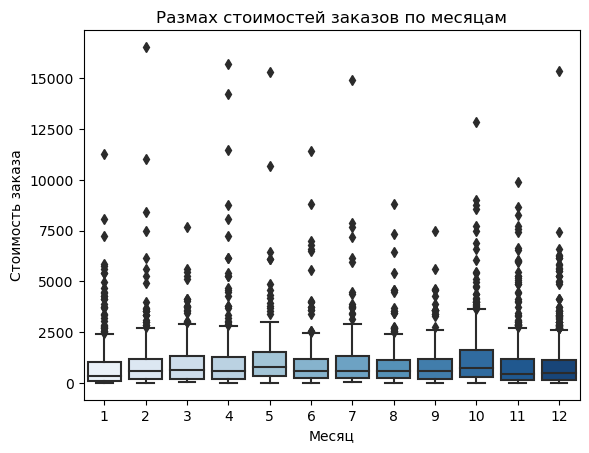

In [29]:
# ящик с усами по месяцам
ax = sns.boxplot(x = "month", y = "value", data=orders, palette="Blues")

ax.set(xlabel='Месяц', ylabel='Стоимость заказа', title='Размах стоимостей заказов по месяцам')
plt.show()

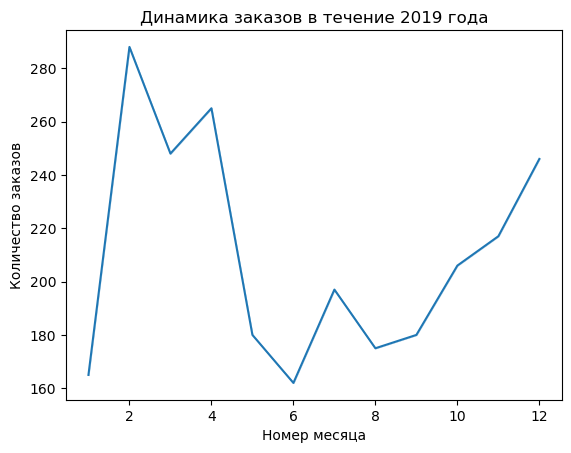

In [30]:
# количество заказов по месяцам буду анализировать только по 2019 году
# это уберет смещение по месяцам, по которым есть данные за несколько лет
orders_2019 = orders.query('year == 2019')

# сумма заказов по месяцам 2019
orders_2019['volume'] = orders_2019.groupby('month')['order_id'].transform('nunique')

# выручка по месяцам 2019
orders_2019['total_rev'] = orders_2019.groupby('month')['value'].transform('sum')

# график
ax = sns.lineplot(x = "month", y = "volume", data=orders_2019, palette="Blues")
ax.set(xlabel='Номер месяца', ylabel='Количество заказов', title='Динамика заказов в течение 2019 года')

plt.show()

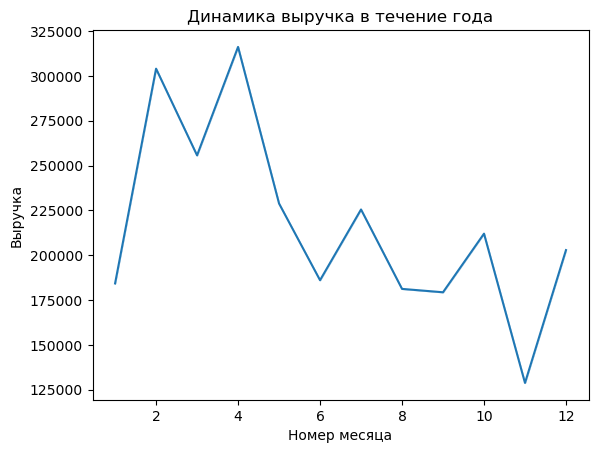

In [31]:
# датафрейм для графика и график
ax = sns.lineplot(x = "month", y = "total_rev", data=orders_2019, palette="Blues")
ax.set(xlabel='Номер месяца', ylabel='Выручка', title='Динамика выручка в течение года')
plt.show()

- Наибольшие стоимости заказов наблюдались в мае и октябре, чуть меньше в марте и сентябре. Меньше всего в январе и ноябре;
- Пик числа заказов приходится на февраль. Также много в апреле, марте, ноябре и декабре. «Затишье» в июне, немногим больше в январе, мае, августе и сентябре;
- Итого по выручке лучшие период: февраль - апрель. Хуже всего в ноябре, июне и августе.

#### Зависимость числа и объема заказов от временных интервалов в разные дня недели

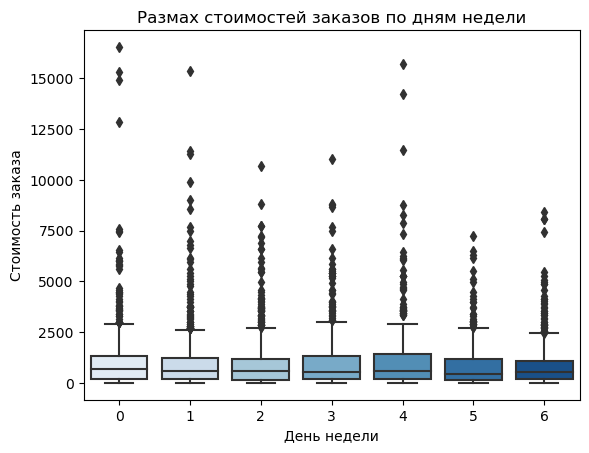

In [32]:
# ящик с усами по месяцам
ax = sns.boxplot(x = "weekday", y = "value", data=orders, palette="Blues")
ax.set(xlabel='День недели', ylabel='Стоимость заказа', title='Размах стоимостей заказов по дням недели')
#sns.set(rc={'figure.figsize':(7, 15)})
plt.show()

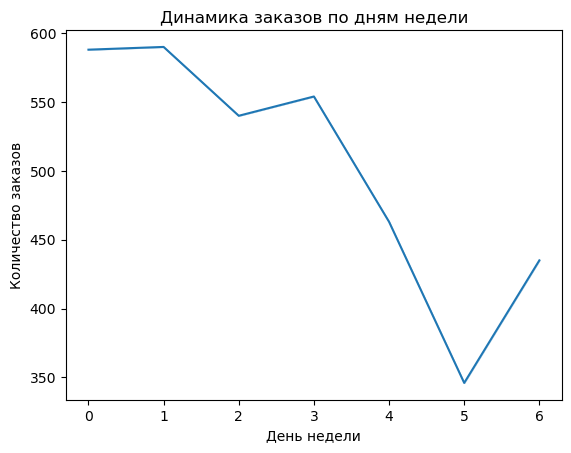

In [33]:
# заказы по дням недели
orders['volume'] = orders.groupby('weekday')['order_id'].transform('count')

# график
ax = sns.lineplot(x = "weekday", y = "volume", data=orders, palette="Blues")
ax.set(xlabel='День недели', ylabel='Количество заказов', title='Динамика заказов по дням недели')
plt.show()

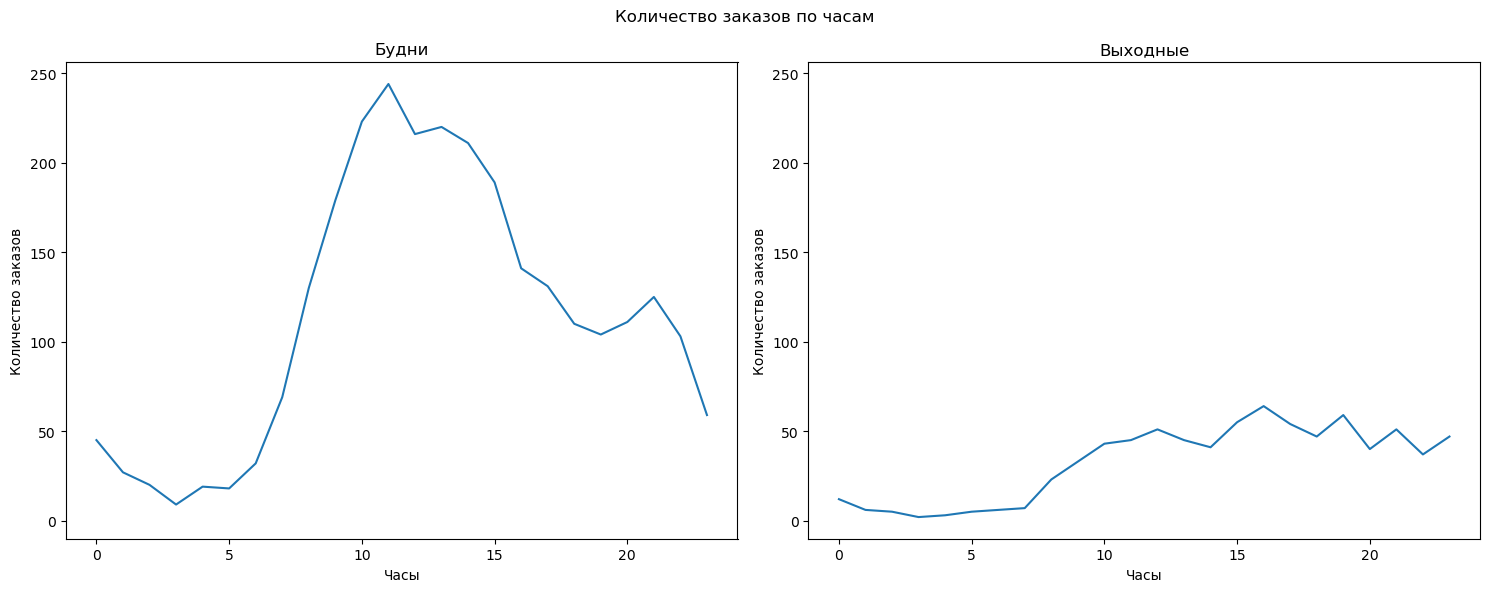

In [34]:
# датафрейм для графика и график
work_days = orders.query('weekday < 5')\
    .groupby('hour').agg(volume=('order_id', 'count')).reset_index()

weekend = orders.query('weekday >= 5')\
    .groupby('hour').agg(volume=('order_id', 'count')).reset_index()

# график
fig = plt.figure(figsize=(15,6))
fig.suptitle('Количество заказов по часам')

# будни
ax1 = fig.add_subplot(121)
sns.lineplot(x = "hour", y = "volume", data=work_days, palette="Blues")
ax1.set(xlabel='Часы', ylabel='Количество заказов', title='Будни')

# выходные
ax2 = fig.add_subplot(122, sharey=ax1)
sns.lineplot(x = "hour", y = "volume", data=weekend, palette="Blues")
ax2.set(xlabel='Часы', ylabel='Количество заказов', title='Выходные')

plt.tight_layout()
plt.show()

- Больше заказов посетители сайта делают в понедельник, вторник и четверг, наблюдается неболшой спад к среде и заметное снижение в пятницу-субботу, легкое восстановление в воскресенье, но оно не дотягивает до значений будней;
- Медианный чек примерно одинаковый, на выходных - немного ниже;
- В будни большинство заказов совершается с 9 до 16, пик в 11, есть подъем в 21 час;
- По выходным большинство заказов после 10 часов, пик в 15.

#### Анализ поведения пользователей: как часто заказывают, среднее число заказов на пользователя, доля пользователей с более чем одной покупкой

In [35]:
# датафрейм по покупателям
customers = (data
            .groupby('customer_id')
            .agg(num_orders=('order_id', 'nunique'), val_orders=('value', 'sum'))
           ).reset_index().sort_values(by='val_orders', ascending=False)

# средняя покупка
customers['avg'] = customers['val_orders'] / customers['num_orders']

customers.sort_values(by='avg', ascending=False).head(3)

,customer_id,num_orders,val_orders,avg
1350,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,1,16536.0,16536.0
863,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,15300.0,15300.0
133,0d87f4ae-465a-4fac-81e6-5d629761783e,1,14917.0,14917.0


In [36]:
customers.describe()

,num_orders,val_orders,avg
count,2426.000000,2426.000000,2426.000000
mean,1.449711,1540.478737,1099.759479
std,2.691136,3942.849557,1416.959217
min,1.000000,15.000000,15.000000
25%,1.000000,391.500000,300.000000
50%,1.000000,830.500000,642.500000
75%,2.000000,1790.333333,1322.250000
max,126.000000,159508.000000,16536.000000


In [37]:
# найду 99 процентиль по параметрам
print('Заказов на пользователя:', round(np.percentile(customers['num_orders'], 99),1))
print('Сумма всех заказов:', round(np.percentile(customers['val_orders'], 99),1))

Заказов на пользователя: 3.0
Сумма всех заказов: 8723.8


In [38]:
# количество пользователей по числу заказов

# все пользователи
all_cust = len(customers)

# пользователи с более чем одним заказом
one_plus_cust = len(customers.query('num_orders > 1'))
print('Доля тех, кто сделал два и более заказов: {:.2f}%'.format(one_plus_cust / all_cust * 100))
      
# пользователи с более чем двумя заказами
two_plus_cust = len(customers.query('num_orders > 2'))
print('Доля тех, кто сделал три и более заказов: {:.2f}%'.format(two_plus_cust / all_cust * 100))

Доля тех, кто сделал два и более заказов: 36.48%
Доля тех, кто сделал три и более заказов: 1.15%


- 37% пользователей сделали повторный заказ, а чуть более 1% - три и более;
- В среднем пользователи совершали от 1 до 2 заказов общей суммой от 390 до 1790;
- 99% клиентов совершили не более трех заказов общей суммой не выше 8,7 тысяч.

#### Продаваемость категорий товаров

In [39]:
# датафрейм с товарами
products = (data
            .groupby(['year', 'month', 'day', 'hour', 'weekday', 'group', 'product', 'price'])
            .agg(value=('value', 'sum'), sold=('quantity', 'sum'))
           ).reset_index()

products.head(1)

,year,month,day,hour,weekday,group,product,price,value,sold
0,2018,10,2018-10-01,0,0,Растения,"Комнатное растение в горшке Алое Вера, d12, h30",142.0,142.0,1


In [40]:
products_total = (products
                  .groupby(['year', 'month', 'group', 'product'])
                  .agg(total=('value', 'sum'), number=('sold', 'sum'))
                  .reset_index()
                 )
# топ товаров по количеству продаж                  
products_total.sort_values(by=['number'], ascending=False)

,year,month,group,product,total,number
502,2018,11,Растения,Муляж ЯБЛОКО 9 см красное,16989.0,311
2252,2019,5,Растения,Муляж ЯБЛОКО 9 см красное,15300.0,300
727,2018,12,Полезные мелочи,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",5800.0,200
343,2018,10,Товары для ремонта,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,5700.0,150
1694,2019,3,Товары для спальни,Плечики пластмассовые Размер 52 - 54 Тула 1205158,3000.0,150
...,...,...,...,...,...,...
1728,2019,4,Полезные мелочи,Сумка-тележка хозяйственная Andersen Scala Sho...,5249.0,1
1729,2019,4,Полезные мелочи,Сумка-тележка хозяйственная GIMI Ideal синяя,1649.0,1
1730,2019,4,Полезные мелочи,Сумка-тележка хозяйственная Rolser MNB019 rojo...,8077.0,1
1731,2019,4,Полезные мелочи,Сумка-тележка хозяйственная RolserJet C. Capri...,3329.0,1


In [41]:
# распределение
products_total[['total', 'number']].describe()

,total,number
count,4274.000000,4274.000000
mean,874.403701,3.000702
std,1451.075527,10.311722
min,9.000000,1.000000
25%,134.000000,1.000000
50%,338.000000,1.000000
75%,974.000000,2.000000
max,16989.000000,311.000000


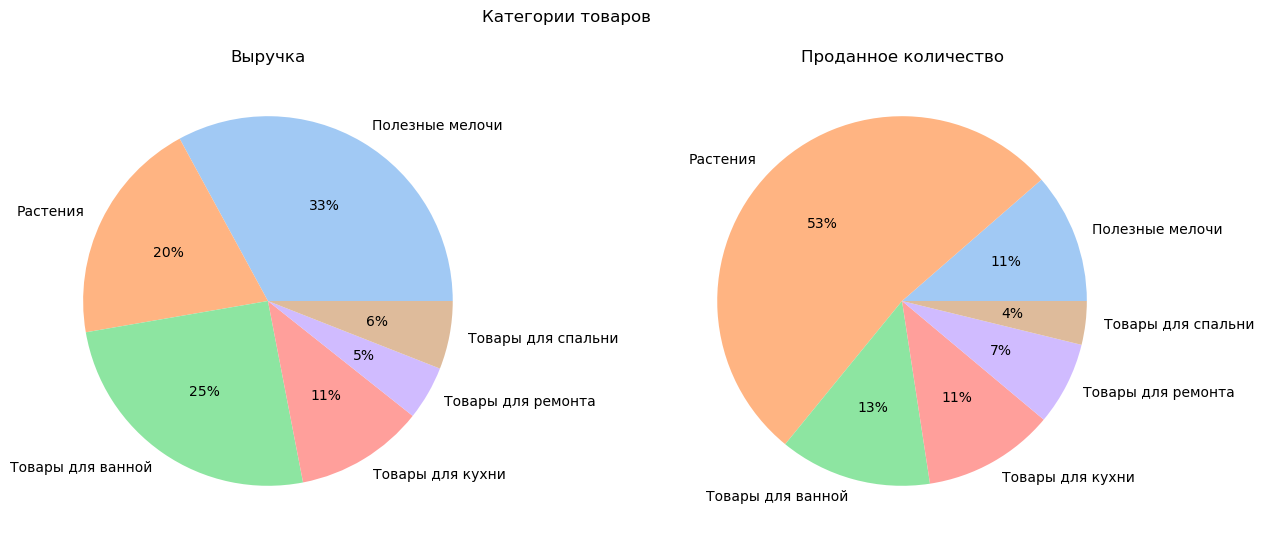

In [42]:
# датафрейм для графиков
raw = products_total.groupby('group').agg(total=('total', 'sum'), number=('number', 'sum')).reset_index()

# выбор цвета
colors = sns.color_palette('pastel')[0:6]

fig = plt.figure(figsize=(15,6))
fig.suptitle('Категории товаров')

# выручка
ax1 = fig.add_subplot(121)
plt.pie(raw['total'], labels = raw['group'], colors = colors, autopct='%.0f%%')
ax1.set_title('Выручка')

# кол-во
ax2 = fig.add_subplot(122)
plt.pie(raw['number'], labels = raw['group'], colors = colors, autopct='%.0f%%')
ax2.set_title('Проданное количество')

plt.show()

- Наибольший вклад по деньгам приносят `полезные мелочи` (33%), а в штуках они на четвертом месте (11%);
- 25% выручки делают `товары для ванной` и 13% от проданного количества;
- `Растения` составляют 20% выручки и более половины от всего проданного количества (53%);
- `Товары для кухни` занимают  по 11% в денежном и количественном выражении;
- Меньше 7% у товаров для `спальни` и `ремонта`.

Далее изучу доли категорий в выручке по месяцам 2019

In [43]:
# датасет с категориями по месяцам 2019
raw_month = products_total.query('year == 2019')\
    .groupby(['month', 'group']).agg(total=('total', 'sum'), number=('number', 'sum')).reset_index()

# вспомогательный сет
help_t = products_total.query('year == 2019')\
    .groupby(['month']).agg(total_all=('total', 'sum'), number_all=('number', 'sum')).reset_index()

# объединение
raw_month = raw_month.merge(help_t, on='month', how='left')

# доли
raw_month['total_share'] = raw_month['total'] / raw_month['total_all']
raw_month['number_share'] = raw_month['number'] / raw_month['number_all']

raw_month.head()

,month,group,total,number,total_all,number_all,total_share,number_share
0,1,Полезные мелочи,32118.0,45,184272.0,604,0.174297,0.074503
1,1,Растения,28441.0,193,184272.0,604,0.154342,0.319536
2,1,Товары для ванной,52555.0,135,184272.0,604,0.285203,0.223510
3,1,Товары для кухни,37186.0,191,184272.0,604,0.201800,0.316225
4,1,Товары для ремонта,13192.0,8,184272.0,604,0.071590,0.013245


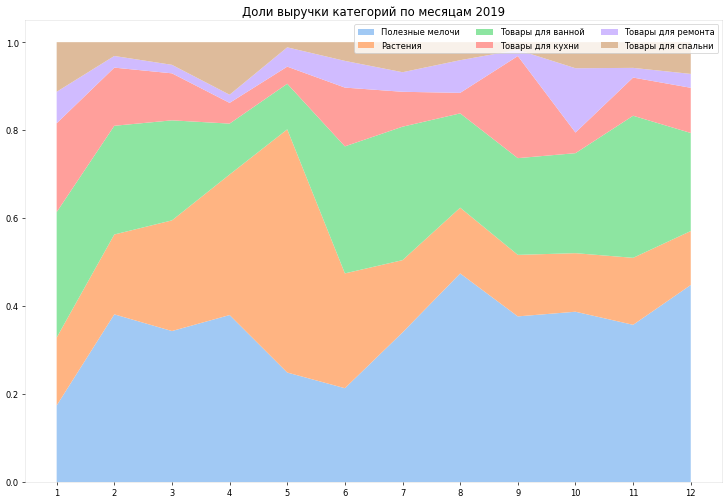

In [44]:
# выручка 
item = 'total_share'

# палитра
mycolors = sns.color_palette('pastel')[0:6]    

fig, ax = plt.subplots(1,1,figsize=(15, 10), dpi= 60)

columns = [
    'Полезные мелочи', 
    'Растения', 
    'Товары для ванной', 
    'Товары для кухни', 
    'Товары для ремонта', 
    'Товары для спальни'
]

labs = columns

# Данные
x  = list(range(1, 13))
y0 = raw_month.query('group == "Полезные мелочи"')[item].values.tolist()
y1 = raw_month.query('group == "Растения"')[item].values.tolist()
y2 = raw_month.query('group == "Товары для ванной"')[item].values.tolist()
y3 = raw_month.query('group == "Товары для кухни"')[item].values.tolist()
y4 = raw_month.query('group == "Товары для ремонта"')[item].values.tolist()
y5 = raw_month.query('group == "Товары для спальни"')[item].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4, y5])

ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors)

plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(fontsize=10)

ax.set_title('Доли выручки категорий по месяцам 2019', fontsize=14)
ax.legend(fontsize=10, ncol=3)

plt.gca().spines["top"].set_alpha(0.1)
plt.gca().spines["bottom"].set_alpha(0.1)
plt.gca().spines["right"].set_alpha(0.1)
plt.gca().spines["left"].set_alpha(0.1)

plt.show()

- Доля `полезных мелочей` в выручке колеблется от 18 до 38%, провал в начале лета, пик в августе;
- Спрос на `растения` наибольший в апреле и мае (садовый сезон), в другое время ровный - около 10 %;
- `Товары для ванной` приносят около 20%, спад в апреле и мае;
- Продажи `товаров для кухни` составляют около 17% в начале года, снижаются до 5% в период с апреля по июнь;
- `Товары для ремонта` лучше продаются летом и в середине осени; 
- `Товары для спальни` продаются равномерно в течение года, небольшой рост в марте и декабре из-за праздников.

#### Ранжирование товаров по выручке и проданному количеству внутри каждой категории

In [45]:
# разбивка на категории и продукты
product_month = (products_total
    .groupby(['group', 'product'])
    .agg(rev=('total', 'sum'), count=('number', 'sum'))
    .reset_index())

# общие продажи в денежном и количественном выражении уже считал
# датафрейм raw
fin_groups = product_month.merge(raw, on='group', how='left')

fin_groups['rev_share'] = fin_groups['rev'] / fin_groups['total']
fin_groups['count_share'] = fin_groups['count'] / fin_groups['number']

# удалю вспомогательные столбцы
fin_groups = fin_groups.drop(columns=['rev', 'count', 'total', 'number']).reset_index(drop=True)

# сортировка
fin_groups = fin_groups.sort_values(by='rev_share', ascending=False)

fin_groups.head(10)

,group,product,rev_share,count_share
2263,Товары для спальни,Одеяло Wellness T142 белое темостеганое 140х20...,0.077447,0.022495
2082,Товары для кухни,Сушилка Meliconi Stendy Junior,0.066350,0.003394
2259,Товары для спальни,Наматрацник Natures Бархатный бамбук ББ-Н-1-2 ...,0.063743,0.024540
2221,Товары для ремонта,Стремянки Colombo Leonardo 2 ступени G300A02W ...,0.051028,0.003212
2222,Товары для ремонта,Стремянки Colombo Leonardo 3 ступени G300A03W ...,0.045079,0.002141
698,Растения,Муляж ЯБЛОКО 9 см красное,0.044236,0.091420
2200,Товары для ремонта,Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 ...,0.043808,0.001071
2275,Товары для спальни,Покрывало жаккард шенилл BIRHOME VALENTIN 240х...,0.043636,0.004090
2220,Товары для ремонта,Стремянки Colombo Leonardo 2 ступени G300A02W ...,0.042107,0.002141
156,Полезные мелочи,Сумка-тележка 2-х колесная Gimi Argo синяя,0.040959,0.032148


Самыми "выручкоёмкими" товара являются стремянки. По отдельным позициям лидер одеяло и покрывало. 

*Выводы по исследовательскому анализу данных сделаны в каждом разделе, общий - в конце проекта*

### ABC-анализ

In [46]:
# накопительный процент по выручке
fin_groups['revenue_cumulative'] = fin_groups.groupby('group')['rev_share'].transform('cumsum')
fin_groups.head()

,group,product,rev_share,count_share,revenue_cumulative
2263,Товары для спальни,Одеяло Wellness T142 белое темостеганое 140х20...,0.077447,0.022495,0.077447
2082,Товары для кухни,Сушилка Meliconi Stendy Junior,0.066350,0.003394,0.066350
2259,Товары для спальни,Наматрацник Natures Бархатный бамбук ББ-Н-1-2 ...,0.063743,0.024540,0.141190
2221,Товары для ремонта,Стремянки Colombo Leonardo 2 ступени G300A02W ...,0.051028,0.003212,0.051028
2222,Товары для ремонта,Стремянки Colombo Leonardo 3 ступени G300A03W ...,0.045079,0.002141,0.096107


In [47]:
# накопительный процент по количеству
fin_groups.sort_values(by='count_share', ascending=False)
fin_groups['count_cumulative'] = fin_groups.groupby('group')['count_share'].transform('cumsum')
fin_groups.head()

,group,product,rev_share,count_share,revenue_cumulative,count_cumulative
2263,Товары для спальни,Одеяло Wellness T142 белое темостеганое 140х20...,0.077447,0.022495,0.077447,0.022495
2082,Товары для кухни,Сушилка Meliconi Stendy Junior,0.066350,0.003394,0.066350,0.003394
2259,Товары для спальни,Наматрацник Natures Бархатный бамбук ББ-Н-1-2 ...,0.063743,0.024540,0.141190,0.047035
2221,Товары для ремонта,Стремянки Colombo Leonardo 2 ступени G300A02W ...,0.051028,0.003212,0.051028,0.003212
2222,Товары для ремонта,Стремянки Colombo Leonardo 3 ступени G300A03W ...,0.045079,0.002141,0.096107,0.005353


In [48]:
# распределение товаров по трем категориям: A - до 80%, B - 80-95%, C - от 95%.
cut_labels = ['A', 'B', 'C']
cut_bins = [0, 0.8, 0.95, 1]

# по выручке
fin_groups['cut_rev'] = pd.cut(fin_groups['revenue_cumulative'],
                      bins=cut_bins,
                      labels=cut_labels)

# по количеству
fin_groups['cut_count'] = pd.cut(fin_groups['count_cumulative'],
                        bins=cut_bins,
                        labels=cut_labels)

fin_groups = fin_groups.reset_index(drop=True)
fin_groups.head()

,group,product,rev_share,count_share,revenue_cumulative,count_cumulative,cut_rev,cut_count
0,Товары для спальни,Одеяло Wellness T142 белое темостеганое 140х20...,0.077447,0.022495,0.077447,0.022495,A,A
1,Товары для кухни,Сушилка Meliconi Stendy Junior,0.066350,0.003394,0.066350,0.003394,A,A
2,Товары для спальни,Наматрацник Natures Бархатный бамбук ББ-Н-1-2 ...,0.063743,0.024540,0.141190,0.047035,A,A
3,Товары для ремонта,Стремянки Colombo Leonardo 2 ступени G300A02W ...,0.051028,0.003212,0.051028,0.003212,A,A
4,Товары для ремонта,Стремянки Colombo Leonardo 3 ступени G300A03W ...,0.045079,0.002141,0.096107,0.005353,A,A


In [49]:
# товары по типам влияния на продажи интернет-магазина: "основные", "дополнительные" и "можно избавиться"
for i in range(len(fin_groups['product'])): 
    if fin_groups.loc[i, 'cut_rev'] == 'A' or fin_groups.loc[i, 'cut_count'] == 'A':
        fin_groups.loc[i, 'type'] = 'Основной товар'
    elif fin_groups.loc[i, 'cut_rev'] == 'C' and fin_groups.loc[i, 'cut_count'] == 'C':
        fin_groups.loc[i, 'type'] = 'Можно избавиться'
    else: 
        fin_groups.loc[i, 'type'] = 'Дополнительный товар'

fin_groups.sample(5)

,group,product,rev_share,count_share,revenue_cumulative,count_cumulative,cut_rev,cut_count,type
2029,Растения,"Муляж Долька Арбуза 14*7,5 см",0.000160,0.000296,0.980894,0.948964,C,B,Дополнительный товар
1895,Полезные мелочи,"Коробка прямоугольная Полимербыт ПРОВАНС 5,5 л...",0.000206,0.001368,0.996325,0.957592,C,C,Можно избавиться
1581,Растения,Шеффлера Голд Капелла d-12 см h-25 см,0.000403,0.000296,0.892720,0.829734,B,B,Дополнительный товар
481,Полезные мелочи,Этажерка для обуви НИКА ЭТП3/З с ящиком золотой,0.003198,0.002052,0.781933,0.579343,A,A,Основной товар
2227,Растения,Космея Попсокс розовая 10 шт 4650091480555,0.000060,0.000296,0.996563,0.981805,C,C,Можно избавиться


In [50]:
# доля каждого типа
for i in ['Основной товар', 'Дополнительный товар', 'Можно избавиться']:
    x = len(fin_groups.query('type == @i')) / len(fin_groups) * 100
    print(i, '{:.0f}%'.format(x))

Основной товар 51%
Дополнительный товар 31%
Можно избавиться 18%


In [51]:
# какая часть товаров каждой категории попала в "можно избавиться"

# общее количество
fin_groups['total_count'] = fin_groups.groupby('group')['product'].transform('nunique')

# количество под удаление
fin_groups['C&С_count'] = fin_groups.query('type == "Можно избавиться"').groupby('group')['product'].transform('nunique')

# датафрейм
throw_data = fin_groups.query('type == "Можно избавиться"').drop_duplicates(subset=['group'])[['group','total_count','C&С_count']]

# доли
throw_data['share'] = round(throw_data['C&С_count'] / throw_data['total_count'] * 100)

# сортировка
throw_data = throw_data.sort_values(by='share', ascending=False)

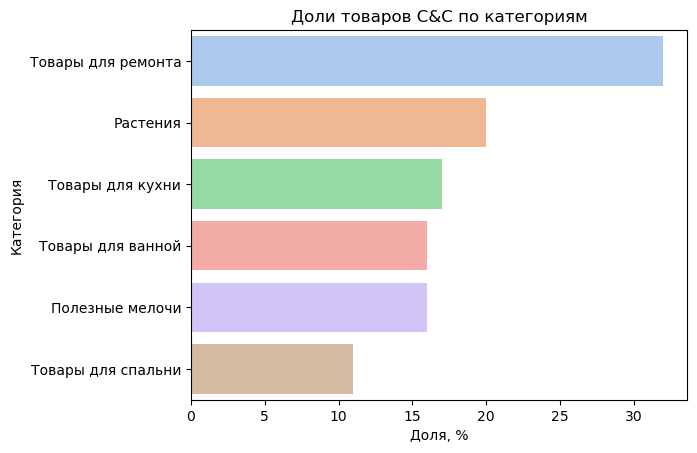

In [52]:
# график
ax = sns.barplot(y='group', x='share', data=throw_data, palette="pastel")


plt.title('Доли товаров C&C по категориям')
plt.xlabel('Доля, %')
plt.ylabel('Категория')

plt.show()

Больше всего товарных позиций по удаление из `товаров для ремонта` (30%). Затем идут `растения` (20%), `кухня` (17%), `ванная` и `полезные мелочи` - по 16%. Самыми полезными позициями стали `товары для спальни`, под удаление только 11%.

In [53]:
# товары, от которых можно избавиться
throw_list = fin_groups.query('type == "Можно избавиться"')
throw_list = throw_list[['group', 'product']].sort_values(by=['group', 'product'])
throw_list

,group,product
2075,Полезные мелочи,Ёрш радиаторный без ручки 1807007
2093,Полезные мелочи,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN...
1868,Полезные мелочи,"Бидон пластмассовый 5,0 л (Иж) 1401119"
2122,Полезные мелочи,Ведро Полимербыт ГРИБЫ 9 л 4314103
1869,Полезные мелочи,Ведро без крышки Полимербыт Лаванда 9 л 4314108
...,...,...
1244,Товары для спальни,"Штора для ванной и душа текстильная, 180х200см..."
1728,Товары для спальни,Штора для ванной комнаты ПВХ 180х180 см Водоро...
1325,Товары для спальни,Штора для ванной комнаты ПВХ 180х180 см Ракушк...
1116,Товары для спальни,Штора для ванной комнаты полиэстер Dasch 180х1...


- Основного товара 51%, это тот товар, который приносит до 80% выручки или проданного количества;
- Дополнительного товара 31%;
- От 18% товарных наименований можно избавиться, они приносят наименьший вклад в выручку.
- Больше всего товарных позиций на удаление в категории `товары для ремонта` и `растения`, затем `кухня` и `ванная`, `полезные мелочи`. Меньше всего - `товары для спальни`.

### Гипотезы

In [54]:
# Подготовка датафрейма для проверки гипотез

# список уникальных заказов
list = orders['order_id'].unique()

# датафрейм продаж с указанием типа продукта (основной, дополнительный, можно избавиться)
df = data.query('order_id in @list')
df = df.merge(fin_groups[['product', 'cut_rev', 'cut_count', 'type']], on='product', how='left')

In [55]:
df.head()

,date,customer_id,order_id,product,quantity,price,value,day,hour,weekday,month,year,sku,group,cut_rev,cut_count,type
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10-01,0,0,10,2018,комнатное растение,Растения,B,A,Основной товар
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10-01,0,0,10,2018,комнатное растение,Растения,B,A,Основной товар
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,0,0,10,2018,радермахера d-12,Растения,C,C,Можно избавиться
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10-01,0,0,10,2018,хризолидокарпус лутесценс,Растения,B,A,Основной товар
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,0,0,10,2018,циперус зумула,Растения,A,A,Основной товар


#### Различаются ли средние стоимости основных и дополнительных товаров

```
H_0: Средняя стоимость основных товаров = средняя стоимость дополнительных товаров
H_1: Средняя стоимость основных товаров ≠ средняя стоимость дополнительных товаров
alpha = 0.05
```

In [56]:
# значения продаж по типу
main = df.query('type == "Основной товар"')['value']
sub = df.query('type == "Дополнительный товар"')['value']

# уровень статистической значимости
alpha = 0.05 

results = st.ttest_ind(main.to_list(), sub.to_list())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Медиана выборки по основным товарам', '{:.0f}'.format(main.median()))
print('Медиана выборки по дополнительным товарам', '{:.0f}'.format(sub.median()))

p-значение: 2.685864461675029e-46
Отвергаем нулевую гипотезу
Медиана выборки по основным товарам 337
Медиана выборки по дополнительным товарам 157


Значение p-value меньше уровня значимости, отвергаем нулевые гипотезу - средние стоимости основных и дополнительных товаров не равны.

#### Равны ли доли продаж растений весной и осенью 2019

В ходе анализа установлено, что продажи растений (лидер по количеству проданных позиций) подвержены сезонности. Проверю, приносят ли они разный вклад в выручку магазина весной и осенью.

```
H_0: Доля выручки растений весной 2019 = доля выручки растений осенью 2019
H_1: Доля выручки растений весной 2019 ≠ доля выручки растений осенью 2019
alpha = 0.05
```

In [57]:
df_19 = df.query('year == 2019')

# критический уровень статистической значимости
alpha = .05 

# сумма продаж весной и осенью
spring = df_19.query('month in (3, 4, 5)')['value'].sum()
autumn = df_19.query('month in (9, 10, 11)')['value'].sum()

# сумма продаж весной и осенью
fl_spr = df_19.query('month in (3, 4, 5) & group == "Растения"')['value'].sum()
fl_aut = df_19.query('month in (9, 10, 11) & group == "Растения"')['value'].sum()

# доля продаж весной
p1 = fl_spr / spring

# доля продаж осенью
p2 = fl_aut / autumn

# пропорция успехов в комбинированном датасете:
p_combined = (fl_spr + fl_aut) / (spring + autumn)

# разница пропорций в датасетах
difference = p1 - p2

# статистика в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/spring + 1/autumn))

# стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 


p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)


if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Отличия спроса на растения весной и осенью подтвердились, доли выручки значимо разные - весной выше.

In [58]:
# загружу csv для создания дашборда
# df.to_csv('dataset.csv', index=False)

### Общий вывод

Для анализа товарного ассортимента сайта товаров для дома был использован датасет о покупках за период *с 1 октября 2018 по 31 января 2020*. Размер базы после предобработки составил *5,5 тысяч строк*. Товары распределены по категориям `кухня`, `спальня`, `ванная`, `ремонт`, `полезные мелочи` и `растения`.

Информация о заказах:
- Средняя стоимость равна 1063;
- Медиана - 577;
- 99% заказов стоят не более 7331;
- Половина заказов от 192 до 1226.

Динамика заказов:
- Наибольшие стоимости заказов наблюдались в мае и октябре, немного ниже в марте и сентябре. Меньше всего в январе и ноябре;
- Пик числа заказов приходится на февраль. Также много - в апреле, марте, ноябре и декабре. «Затишье» в июне, немногим больше в январе, мае, августе и сентябре;
- Наибольшая выручка показана с отрывом в феврале - апреле. Хуже всего в ноябре, июне и августе;
- Больше заказов посетители сайта делают в понедельник, вторник и четверг, наблюдается небольшой спад в среду и снижение в пятницу-субботу, легкое восстановление в воскресенье, но оно не дотягивает до значений будней;
- Медианный чек по дням примерно одинаковый, на выходных - немного ниже;
- В будни большинство заказов совершается с 9 до 16, пик в 11, есть подъем вечером в 21;
- По выходным заказы совершаются более равномерно после 10 часов, пик в 15.

Пользователи:
- Всего 2426 пользователей совершили заказы, из них 37% сделали более одного, а 1,1% - более двух;
- В среднем пользователи совершали от 1 до 2 заказов общей суммой от 390 до 1790;
- 99% клиентов совершили не более трех.

Продукты:

Наиболее «выручкоемкими» являются стремянки, по отдельным позициям - одеяло и покрывало.


- В среднем по году наибольший вклад по деньгам приносит категория `полезные мелочи` (33%), по проданному числу - на четвертом месте (11%). Доля в выручке колеблется от 18 до 38%, провал в начале лета, пик в августе.


- `Товары для ванной` делают 25% выручки и 13% от проданного количества. Спад продаж в апреле и мае.


- `Растения` составляют 20% выручки и более половины от всего проданного количества (53%). Спрос на них наибольший в апреле и мае (садовый сезон), в другое время ровный - около 10 %.


- `Товары для кухни` занимают  11% в денежном и количественном выражении. Продажи категории составляют около 17% в начале года, снижаются до 5% в период с апреля по июнь.


- Меньше 7% у товаров для `спальни` и `ремонта`. `Товары для спальни` продаются равномерно в течение года, небольшой рост в марте и декабре из-за праздников. `Товары для ремонта` лучше продаются летом и в начале осени.

В ходе ABC-анализа были выделены основные и дополнительные товары, а также позиции под удаление.
- Основной товар (80% выручки или проданного количества) составляет 51%;
- Дополнительный товар 31%;
- От 18% товарных наименований можно избавиться, они приносят наименьший вклад в выручку.
- Больше всего товарных позиций на удаление в категории `товары для ремонта` и `растения`, затем `кухня` и `ванная`, `полезные мелочи`. Меньше всего - `товары для спальни`.

В работе были проверены две гипотезы:
- Средние стоимости основных и дополнительных товаров значимо различаются, у основных - выше;
- Доля продаж растений значимо выше весной 2019, чем осенью.

Рекомендации и их тестирование:
- Убрать из каталога товары с тегом "Можно избавиться" для одной тестовой группы пользователей и сравнить выручку, средний чек, количество заказов всего и на пользователя с контрольной группой (либо с двумя контрольными AAB-тест) за один период;
- В анализе выбраны самые популярные товары по категориям, можно добавить их на стартовую страницу в качестве хитов продаж. Также посчитать выручку, средний чек, количество заказов всего и на пользователя за один период для двух групп (A - старая стартовая без топа продаж, B - новая с топом);
- По анализу видно, что падение выручки в ноябре и летом, а также по субботам, если оценивать недельный промежуток. Предлагаю добавить акции или скидки в какой-то из этих "тихих" периодов. Также AB-тест - со скидками и без - по показателям: выручка, средний чек, количество заказов всего и на пользователя за один период.